# Using a local Telemetry server to monitor a GraphRAG agent

In this notebook, we're building a trip planning swarm which has an objective to create an itinerary together with a customer. The end result will be an itinerary that has route times and distances calculated between activities.

The following diagram outlines the key components of the Swarm, with highlights being:

- **Arize Phoenix to provide transparency using the OpenTelemetry standard**
- FalkorDB agent using a GraphRAG database of restaurants and attractions
- Structured Output agent that will enforce a strict format for the accepted itinerary
- Routing agent that utilises the Google Maps API to calculate distances between activities
- Swarm orchestration utilising context variables

````mdx-code-block
:::note
This notebook has been updated as swarms can now accommodate any ConversableAgent.
:::
````

## Initialize Python environment

- FalkorDB's GraphRAG-SDK is a dependency for this notebook
- Please ensure you have Pydantic version 2+ installed

In [ ]:
!pip install -qU pydantic ag2[graph-rag-falkor-db] ipykernel

## Install Docker Containers

**Note:** This may require a Docker Compose file to get it to work reliably.

### FalkorDB

- UI endpoint:  http://localhost:3000/graph
- sample query:  `match path = ()-[]-() return path`

In [ ]:
# if you run the FalkorDB image with the rm flag it is removed after the container is stopped
# for more information refer to:  https://docs.falkordb.com/

# !docker run -p 6379:6379 -p 3000:3000 -it --rm falkordb/falkordb:latest

import subprocess

# Run the Docker container without interactive mode
subprocess.Popen(["docker", "run", "-p", "6379:6379", "-p", "3000:3000", "--rm", "falkordb/falkordb:latest"])

### Arize Phoenix

- UI endpoint:  http://localhost:6006

In [ ]:
# for more information refer to https://docs.arize.com/phoenix/tracing/integrations-tracing/autogen-support#docker
# !docker run -p 6006:6006 -p 4317:4317 arizephoenix/phoenix:latest

import subprocess

# Run the Docker container without interactive mode
subprocess.Popen(["docker", "run", "-p", "6006:6006", "-p", "4317:4317", "--rm", "arizephoenix/phoenix:latest"])

## Arize Phoenix:  setup and configuration

In [ ]:
!pip install -q arize-phoenix-otel

In [ ]:
from phoenix.otel import register

# defaults to endpoint="http://localhost:4317"
tracer_provider = register(
    project_name="ag2-swarm-graphrag",  # Default is 'default'
    endpoint="http://localhost:4317",  # Sends traces using gRPC
)

In [ ]:
# install python telemetry library requirements
!pip install -q openinference-instrumentation-openai 'httpx<0.28'

In [ ]:
from openinference.instrumentation.openai import OpenAIInstrumentor

OpenAIInstrumentor().instrument(tracer_provider=tracer_provider)

### Google Maps API Key

To use Google's API to calculate travel times, you will need to have enabled the `Directions API` in your Google Maps Platform. You can get an API key and free quota, see [here](https://developers.google.com/maps/documentation/directions/overview) and [here](https://developers.google.com/maps/get-started) for more details.

Once you have your API key, set the environment variable `GOOGLE_MAP_API_KEY` to this value.

NOTE:  If the route planning step is failing, it is likely an environment variable issue which can occur in Jupyter notebooks.  The code in the `update_itinerary_with_travel_times` and  `_fetch_travel_time` functions below could be enhanced to provide better visibility if these API calls fail.  The following code cell can assist.

In [ ]:
import os

os.environ["GOOGLE_MAP_API_KEY"] = os.getenv("GOOGLE_MAP_API_KEY")

### Set Configuration and OpenAI API Key

**Create a OAI_CONFIG_LIST file** in the AG2 project `notebook` directory based on the OAI_CONFIG_LIST_sample file from the root directory.

By default, FalkorDB uses OpenAI LLMs and that requires an OpenAI key in your environment variable `OPENAI_API_KEY`.

You can utilise an OAI_CONFIG_LIST file and extract the OpenAI API key and put it in the environment, as will be shown in the following cell.

Alternatively, you can load the environment variable yourself.

````{=mdx}
:::tip
Learn more about configuring LLMs for agents [here](/docs/topics/llm_configuration).
:::
````

In [ ]:
import os

import autogen

llm_config = autogen.LLMConfig.from_json(path="OAI_CONFIG_LIST", timeout=120).where(tags=["gpt-4o"])

# Put the OpenAI API key into the environment using the config_list or env variable
# os.environ["OPENAI_API_KEY"] = llm_config.config_list[0].api_key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Prepare the FalkorDB GraphRAG database

Using 3 sample JSON data files from our GitHub repository, we will create a specific ontology for our GraphRAG database and then populate it.

Creating a specific ontology that matches with the types of queries makes for a more optimal database and is more cost efficient when populating the knowledge graph.

In [ ]:
from autogen.agentchat.contrib.graph_rag.document import Document, DocumentType

# 3 Files (adjust path as necessary)
input_paths = [
    "../test/agentchat/contrib/graph_rag/trip_planner_data/attractions.jsonl",
    "../test/agentchat/contrib/graph_rag/trip_planner_data/cities.jsonl",
    "../test/agentchat/contrib/graph_rag/trip_planner_data/restaurants.jsonl",
]
input_documents = [Document(doctype=DocumentType.TEXT, path_or_url=input_path) for input_path in input_paths]

### Create Ontology

Entities: Country, City, Attraction, Restaurant

Relationships: City in Country, Attraction in City, Restaurant in City

In [ ]:
from graphrag_sdk import Attribute, AttributeType, Entity, Ontology, Relation

# Attraction + Restaurant + City + Country Ontology
trip_data_ontology = Ontology()

trip_data_ontology.add_entity(
    Entity(
        label="Country",
        attributes=[
            Attribute(
                name="name",
                attr_type=AttributeType.STRING,
                required=True,
                unique=True,
            ),
        ],
    )
)
trip_data_ontology.add_entity(
    Entity(
        label="City",
        attributes=[
            Attribute(
                name="name",
                attr_type=AttributeType.STRING,
                required=True,
                unique=True,
            ),
            Attribute(
                name="weather",
                attr_type=AttributeType.STRING,
                required=False,
                unique=False,
            ),
            Attribute(
                name="population",
                attr_type=AttributeType.NUMBER,
                required=False,
                unique=False,
            ),
        ],
    )
)
trip_data_ontology.add_entity(
    Entity(
        label="Restaurant",
        attributes=[
            Attribute(
                name="name",
                attr_type=AttributeType.STRING,
                required=True,
                unique=True,
            ),
            Attribute(
                name="description",
                attr_type=AttributeType.STRING,
                required=False,
                unique=False,
            ),
            Attribute(
                name="rating",
                attr_type=AttributeType.NUMBER,
                required=False,
                unique=False,
            ),
            Attribute(
                name="food_type",
                attr_type=AttributeType.STRING,
                required=False,
                unique=False,
            ),
        ],
    )
)
trip_data_ontology.add_entity(
    Entity(
        label="Attraction",
        attributes=[
            Attribute(
                name="name",
                attr_type=AttributeType.STRING,
                required=True,
                unique=True,
            ),
            Attribute(
                name="description",
                attr_type=AttributeType.STRING,
                required=False,
                unique=False,
            ),
            Attribute(
                name="type",
                attr_type=AttributeType.STRING,
                required=False,
                unique=False,
            ),
        ],
    )
)
trip_data_ontology.add_relation(
    Relation(
        label="IN_COUNTRY",
        source="City",
        target="Country",
    )
)
trip_data_ontology.add_relation(
    Relation(
        label="IN_CITY",
        source="Restaurant",
        target="City",
    )
)
trip_data_ontology.add_relation(
    Relation(
        label="IN_CITY",
        source="Attraction",
        target="City",
    )
)

### Initialize FalkorDB and Query Engine

Remember: Change your host, port, and preferred OpenAI model if needed (gpt-4o-mini and better is recommended).

In [ ]:
from graphrag_sdk.models.openai import OpenAiGenerativeModel

from autogen.agentchat.contrib.graph_rag.falkor_graph_query_engine import FalkorGraphQueryEngine
from autogen.agentchat.contrib.graph_rag.falkor_graph_rag_capability import FalkorGraphRagCapability

# Create FalkorGraphQueryEngine
query_engine = FalkorGraphQueryEngine(
    name="trip_data",
    host="localhost",  # change to a specific IP address if you run into issues connecting to your local instance
    port=6379,  # if needed
    ontology=trip_data_ontology,
    model=OpenAiGenerativeModel("gpt-4o"),
)

# Ingest data and initialize the database
query_engine.init_db(input_doc=input_documents)

# If you have already ingested and created the database, you can use this connect_db instead of init_db
# query_engine.connect_db()

In [ ]:
# IMPORTS
import json
import os
from typing import Any, Dict

import requests
from pydantic import BaseModel

from autogen import (
    AfterWork,
    AfterWorkOption,
    ConversableAgent,
    OnCondition,
    SwarmResult,
    UserProxyAgent,
    initiate_swarm_chat,
    register_hand_off,
)

### Pydantic model for Structured Output

Utilising OpenAI's [Structured Outputs](https://platform.openai.com/docs/guides/structured-outputs), our Structured Output agent's responses will be constrained to this Pydantic model.

The itinerary is structured as:
Itinerary has Day(s) has Event(s)

In [ ]:
class Event(BaseModel):
    type: str  # Attraction, Restaurant, Travel
    location: str
    city: str
    description: str


class Day(BaseModel):
    events: list[Event]


class Itinerary(BaseModel):
    days: list[Day]

### Google Maps Platform

The functions necessary to query the Directions API to get travel times.

In [ ]:
def _fetch_travel_time(origin: str, destination: str) -> dict:
    """Retrieves route information using Google Maps Directions API.
    API documentation at https://developers.google.com/maps/documentation/directions/get-directions
    """
    endpoint = "https://maps.googleapis.com/maps/api/directions/json"
    params = {
        "origin": origin,
        "destination": destination,
        "mode": "walking",  # driving (default), bicycling, transit
        "key": os.environ.get("GOOGLE_MAP_API_KEY"),
    }

    response = requests.get(endpoint, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return {"error": "Failed to retrieve the route information", "status_code": response.status_code}


def update_itinerary_with_travel_times(context_variables: dict) -> SwarmResult:
    """Update the complete itinerary with travel times between each event."""
    """
    Retrieves route information using Google Maps Directions API.
    API documentation at https://developers.google.com/maps/documentation/directions/get-directions
    """

    # Ensure that we have a structured itinerary, if not, back to the structured_output_agent to make it
    if context_variables.get("structured_itinerary") is None:
        return SwarmResult(
            agent="structured_output_agent",
            values="Structured itinerary not found, please create the structured output, structured_output_agent.",
        )
    elif "timed_itinerary" in context_variables:
        return SwarmResult(values="Timed itinerary already done, inform the customer that their itinerary is ready!")

    # Process the itinerary, converting it back to an object and working through each event to work out travel time and distance
    itinerary_object = Itinerary.model_validate(json.loads(context_variables["structured_itinerary"]))
    for day in itinerary_object.days:
        events = day.events
        new_events = []
        pre_event, cur_event = None, None
        event_count = len(events)
        index = 0
        while index < event_count:
            if index > 0:
                pre_event = events[index - 1]

            cur_event = events[index]
            if pre_event:
                origin = ", ".join([pre_event.location, pre_event.city])
                destination = ", ".join([cur_event.location, cur_event.city])
                maps_api_response = _fetch_travel_time(origin=origin, destination=destination)
                try:
                    leg = maps_api_response["routes"][0]["legs"][0]
                    travel_time_txt = f"{leg['duration']['text']}, ({leg['distance']['text']})"
                    new_events.append(
                        Event(
                            type="Travel",
                            location=f"walking from {pre_event.location} to {cur_event.location}",
                            city=cur_event.city,
                            description=travel_time_txt,
                        )
                    )
                except Exception:
                    print(f"Note: Unable to get travel time from {origin} to {destination}")
            new_events.append(cur_event)
            index += 1
        day.events = new_events

    context_variables["timed_itinerary"] = itinerary_object.model_dump()

    return SwarmResult(context_variables=context_variables, values="Timed itinerary added to context with travel times")

## Swarm

### Context Variables
Our swarm agents will have access to a couple of context variables in relation to the itinerary.

In [ ]:
trip_context = {
    "itinerary_confirmed": False,
    "itinerary": "",
    "structured_itinerary": None,
}

### Agent Functions

We have two functions/tools for our agents.

One for our Planner agent to mark an itinerary as confirmed by the customer and to store the final text itinerary. This will then transfer to our Structured Output agent.

Another for the Structured Output Agent to save the structured itinerary and transfer to the Route Timing agent.

In [ ]:
def mark_itinerary_as_complete(final_itinerary: str, context_variables: Dict[str, Any]) -> SwarmResult:
    """Store and mark our itinerary as accepted by the customer."""
    context_variables["itinerary_confirmed"] = True
    context_variables["itinerary"] = final_itinerary

    # This will update the context variables and then transfer to the Structured Output agent
    return SwarmResult(
        agent="structured_output_agent", context_variables=context_variables, values="Itinerary recorded and confirmed."
    )


def create_structured_itinerary(context_variables: Dict[str, Any], structured_itinerary: str) -> SwarmResult:
    """Once a structured itinerary is created, store it and pass on to the Route Timing agent."""
    # Ensure the itinerary is confirmed, if not, back to the Planner agent to confirm it with the customer
    if not context_variables["itinerary_confirmed"]:
        return SwarmResult(
            agent="planner_agent",
            values="Itinerary not confirmed, please confirm the itinerary with the customer first.",
        )

    context_variables["structured_itinerary"] = structured_itinerary

    # This will update the context variables and then transfer to the Route Timing agent
    return SwarmResult(
        agent="route_timing_agent", context_variables=context_variables, values="Structured itinerary stored."
    )

### Agents

Our Swarm agents and a UserProxyAgent (human) which the swarm will interact with.

In [ ]:
# Planner agent, interacting with the customer and GraphRag agent, to create an itinerary
planner_agent = ConversableAgent(
    name="planner_agent",
    system_message="You are a trip planner agent. It is important to know where the customer is going, how many days, what they want to do."
    + "You will work with another agent, graphrag_agent, to get information about restaurant and attractions. "
    + "You are also working with the customer, so you must ask the customer what they want to do if you don’t have LOCATION, NUMBER OF DAYS, MEALS, and ATTRACTIONS. "
    + "When you have the customer's requirements, work with graphrag_agent to get information for an itinerary."
    + "You are responsible for creating the itinerary and for each day in the itinerary you MUST HAVE events and EACH EVENT MUST HAVE a 'type' ('Restaurant' or 'Attraction'), 'location' (name of restaurant or attraction), 'city', and 'description'. "
    + "Finally, YOU MUST ask the customer if they are happy with the itinerary before marking the itinerary as complete.",
    functions=[mark_itinerary_as_complete],
    llm_config=llm_config,
)

# FalkorDB GraphRAG agent, utilising the FalkorDB to gather data for the Planner agent
graphrag_agent = ConversableAgent(
    name="graphrag_agent",
    system_message="Return a list of restaurants and/or attractions. List them separately and provide ALL the options in the location. Do not provide travel advice.",
)

# Adding the FalkorDB capability to the agent
graph_rag_capability = FalkorGraphRagCapability(query_engine)
graph_rag_capability.add_to_agent(graphrag_agent)

# Structured Output agent, formatting the itinerary into a structured format through the response_format on the LLM Configuration
structured_llm_config = autogen.LLMConfig.from_json(path="OAI_CONFIG_LIST", timeout=120).where(tags=["gpt-4o"])

for config in structured_llm_config.config_list:
    config.response_format = Itinerary

structured_output_agent = ConversableAgent(
    name="structured_output_agent",
    system_message="You are a data formatting agent, format the provided itinerary in the context below into the provided format.",
    llm_config=structured_llm_config,
    functions=[create_structured_itinerary],
)

# Route Timing agent, adding estimated travel times to the itinerary by utilising the Google Maps Platform
route_timing_agent = ConversableAgent(
    name="route_timing_agent",
    system_message="You are a route timing agent. YOU MUST call the update_itinerary_with_travel_times tool if you do not see the exact phrase 'Timed itinerary added to context with travel times' is seen in this conversation. Only after this please tell the customer 'Your itinerary is ready!'.",
    llm_config=llm_config,
    functions=[update_itinerary_with_travel_times],
)

# Our customer will be a human in the loop
customer = UserProxyAgent(name="customer")

### Hand offs and After works

In conjunction with the agent's associated functions, we establish rules that govern the swarm orchestration through hand offs and After works.

For more details on the swarm orchestration, [see the documentation](https://docs.ag2.ai/docs/user-guide/advanced-concepts/swarm/deep-dive).

In [ ]:
register_hand_off(
    agent=planner_agent,
    hand_to=[
        OnCondition(
            graphrag_agent,
            "Need information on the restaurants and attractions for a location. DO NOT call more than once at a time.",
        ),  # Get info from FalkorDB GraphRAG
        OnCondition(structured_output_agent, "Itinerary is confirmed by the customer"),
        AfterWork(AfterWorkOption.REVERT_TO_USER),  # Revert to the customer for more information on their plans
    ],
)


# Back to the Planner when information has been retrieved
register_hand_off(agent=graphrag_agent, hand_to=[AfterWork(planner_agent)])

# Once we have formatted our itinerary, we can hand off to the route timing agent to add in the travel timings
register_hand_off(agent=structured_output_agent, hand_to=[AfterWork(route_timing_agent)])

# Finally, once the route timing agent has finished, we can terminate the swarm
register_hand_off(agent=route_timing_agent, hand_to=[AfterWork(AfterWorkOption.TERMINATE)])

### Run the swarm

Let's get an itinerary for a couple of days in Rome.

In [ ]:
# Start the conversation

chat_result, context_variables, last_agent = initiate_swarm_chat(
    initial_agent=planner_agent,
    agents=[planner_agent, graphrag_agent, structured_output_agent, route_timing_agent],
    user_agent=customer,
    context_variables=trip_context,
    messages="I want to go to Rome for a couple of days. Can you help me plan my trip?",
    after_work=AfterWorkOption.TERMINATE,
    max_rounds=100,
)

### Bonus itinerary output

In [ ]:
def print_itinerary(itinerary_data):
    header = "█             █\n █           █ \n  █  █████  █  \n   ██     ██   \n  █         █  \n █  ███████  █ \n █ ██ ███ ██ █ \n   █████████   \n\n ██   ███ ███  \n█  █ █       █ \n████ █ ██  ██  \n█  █ █  █ █    \n█  █  ██  ████ \n"
    width = 80
    icons = {"Travel": "🚶", "Restaurant": "🍽️", "Attraction": "🏛️"}

    for line in header.split("\n"):
        print(line.center(width))
    print(f"Itinerary for {itinerary_data['days'][0]['events'][0]['city']}".center(width))
    print("=" * width)

    for day_num, day in enumerate(itinerary_data["days"], 1):
        print(f"\nDay {day_num}".center(width))
        print("-" * width)

        for event in day["events"]:
            event_type = event["type"]
            print(f"\n  {icons[event_type]} {event['location']}")
            if event_type != "Travel":
                words = event["description"].split()
                line = "    "
                for word in words:
                    if len(line) + len(word) + 1 <= 76:
                        line += word + " "
                    else:
                        print(line)
                        line = "    " + word + " "
                if line.strip():
                    print(line)
            else:
                print(f"    {event['description']}")
        print("\n" + "-" * width)


if "timed_itinerary" in context_variables:
    print_itinerary(context_variables["timed_itinerary"])
else:
    print("No itinerary available to print.")

## Review FalkorDB Graph

- UI endpoint:  http://localhost:3000/graph
- sample query:  `match path = ()-[]-() return path`

NOTE:  Based on current LLM issues the `trip_data` graph is actually empty...

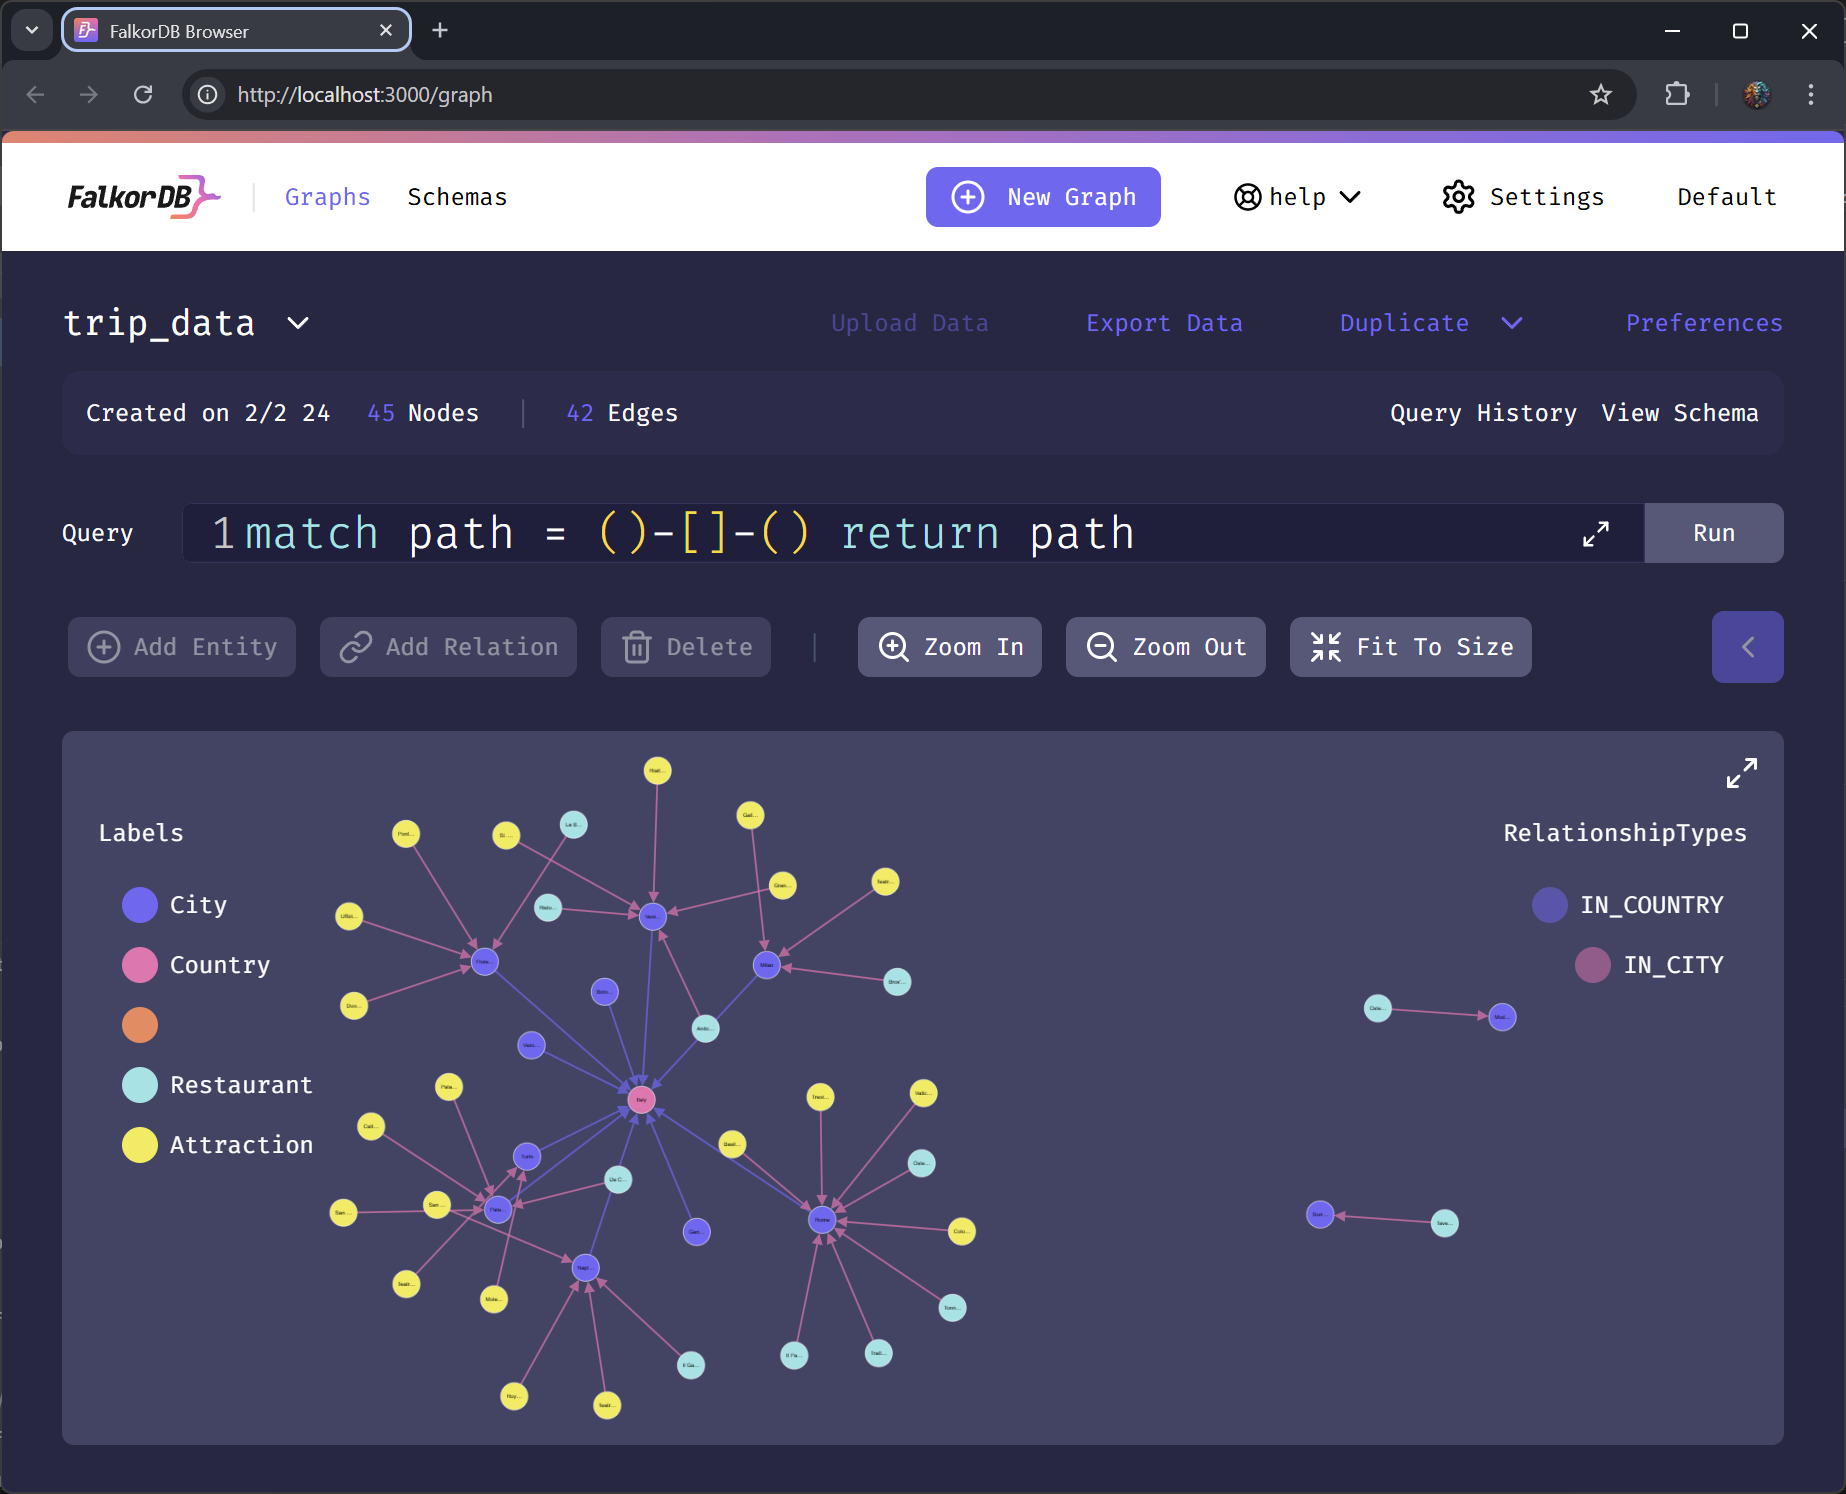

## Review Arize Phoenix Telemetry Info

- UI endpoint:  http://localhost:6006

### Card View

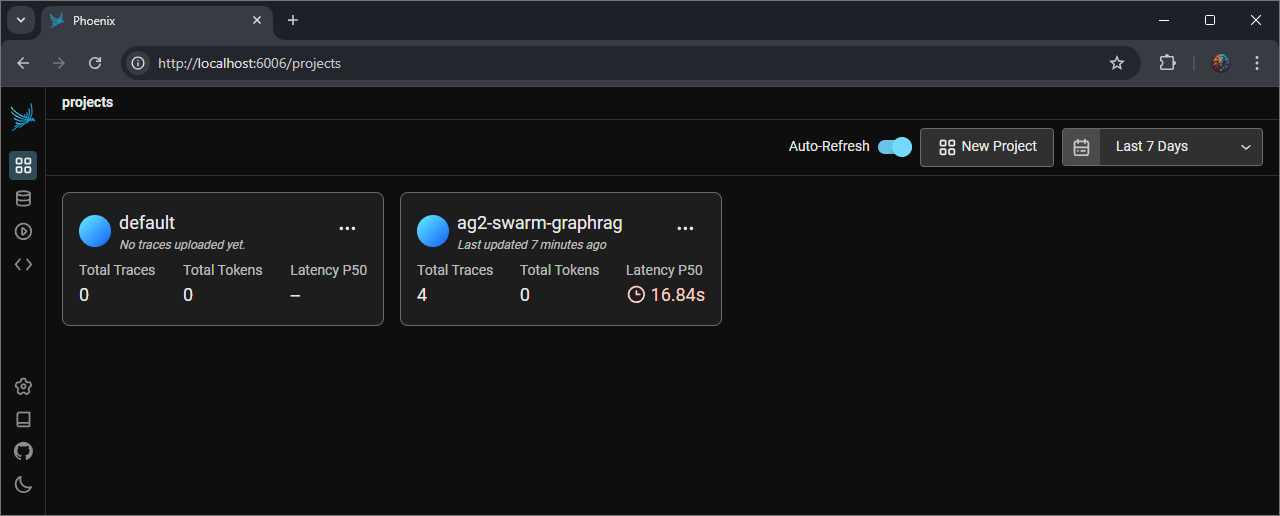

### List View

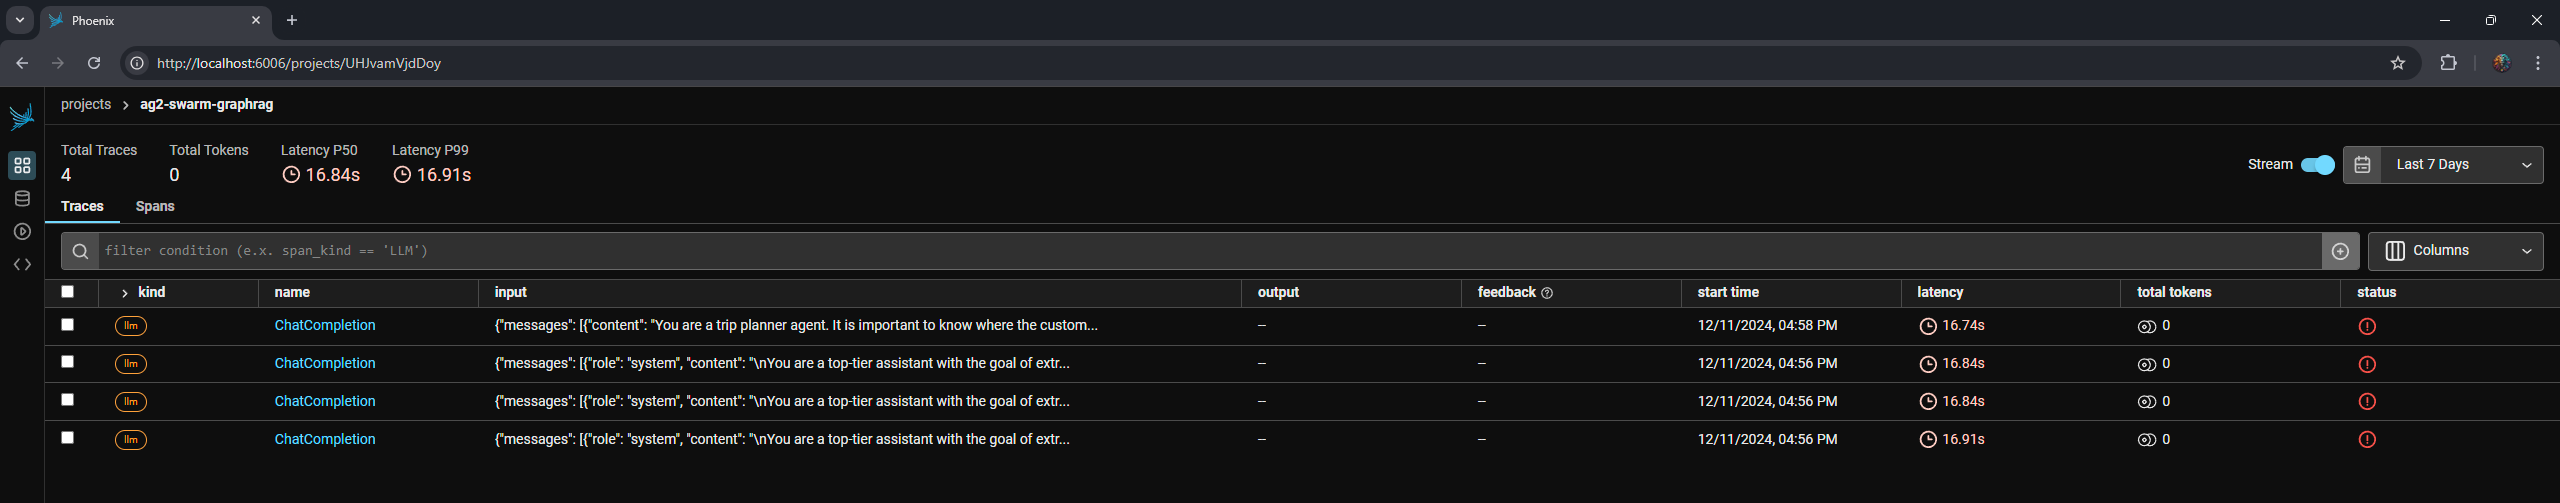

### Detail View - Route Timing Agent - LLM error

NOTE:  this was based on LLM issues at the time of the test.  A key reason why telemetry information is so valuable.

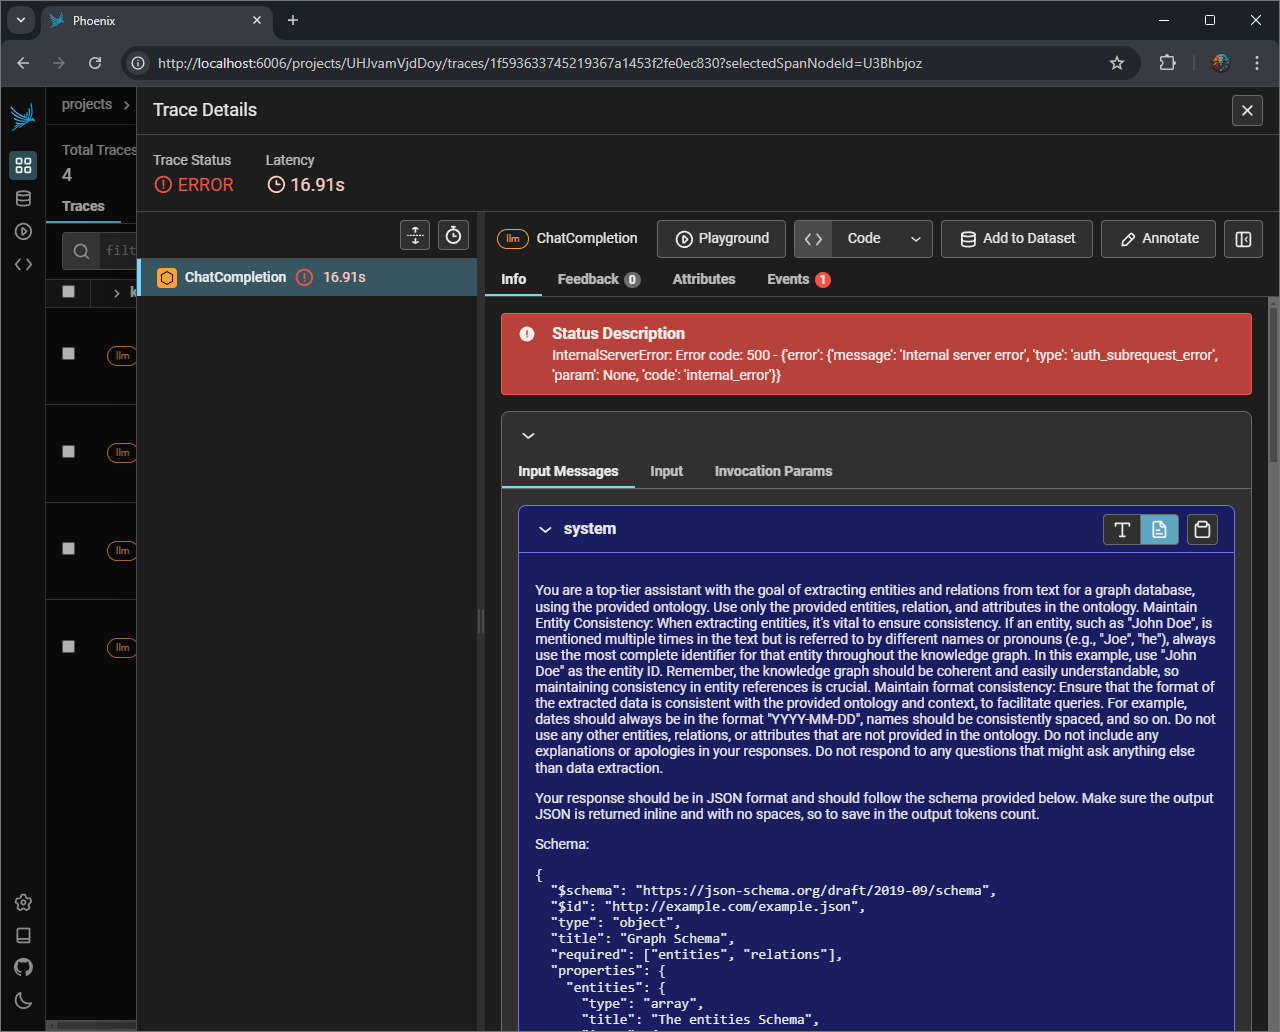

### Detail View - Route Timing Agent - working normally

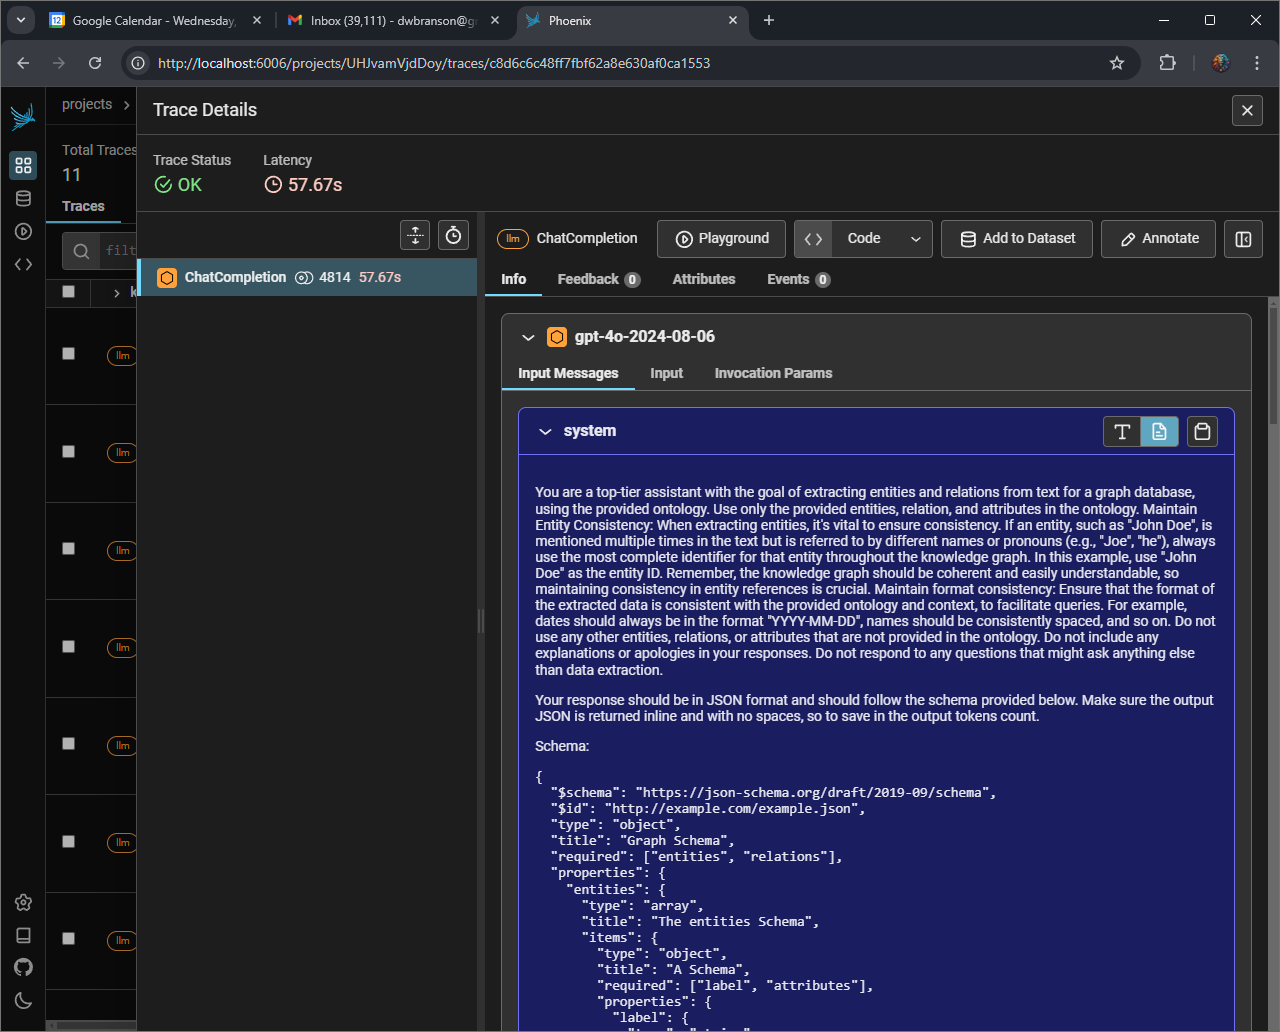